[1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, ... 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1]
[1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, ... 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1]


(array([ 8228.,  9035.,  9624., 10447., 11068., 11652., 12633., 13575.,
        14666., 15612., 16815., 18180., 19541., 21065., 22981., 24949.,
        27515., 29858., 32704., 35823., 38704., 41355., 41764., 32588.,
         9430.,  9730., 33115., 42543., 41654., 38601., 35860., 32884.,
        29817., 27346., 25018., 23023., 21451., 19626., 18003., 16743.,
        15334., 14789., 13454., 12433., 11604., 10882., 10287.,  9608.,
         8794.,  8285.]),
 array([-1200., -1152., -1104., -1056., -1008.,  -960.,  -912.,  -864.,
         -816.,  -768.,  -720.,  -672.,  -624.,  -576.,  -528.,  -480.,
         -432.,  -384.,  -336.,  -288.,  -240.,  -192.,  -144.,   -96.,
          -48.,     0.,    48.,    96.,   144.,   192.,   240.,   288.,
          336.,   384.,   432.,   480.,   528.,   576.,   624.,   672.,
          720.,   768.,   816.,   864.,   912.,   960.,  1008.,  1056.,
         1104.,  1152.,  1200.]),
 <BarContainer object of 50 artists>)

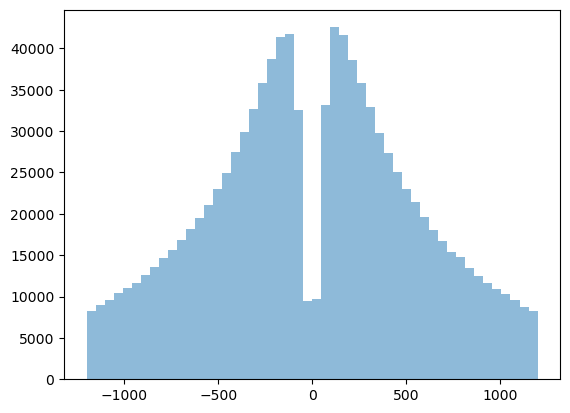

In [1]:
import uproot
import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
input_tree = uproot.open({"/work/guenther/reco_tuner/data/param_data_selected_all_p.root": "Selected"})
array = input_tree.arrays()
array["dSlope_fringe"] = array["tx_ref"] - array["tx"]
array["z_mag_x_fringe"] = (array["x"] - array["x_ref"] - array["tx"] * array["z"] + array["tx_ref"] * array["z_ref"] ) / array["dSlope_fringe"]
array["x_straight_diff_ref"] = array["x"] + array["tx"] * (array["z_ref"] - array["z"]) - array["x_ref"]
array["x_straight_diff_ref_abs"] = abs(array["x_straight_diff_ref"])
array["inv_p_gev"] = 1000. / array["p"]
array["pol_qop_gev"] = array["signed_rel_current"] * array["qop"] * 1000.
array["qop_gev"] = array["qop"] * 1000.
array["deflection_sign"] = array["pol_qop_gev"] / array["inv_p_gev"]
print(array["deflection_sign"])
print(array["x_straight_diff_ref"] / array["x_straight_diff_ref_abs"])
plt.figure()
plt.hist(array["x_straight_diff_ref"], bins=50,
        range=[-1200, 1200], alpha=0.5)

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

features = [
    "ty", 
    "tx",
    "inv_p_gev",
    "pol_qop_gev"
]
target_feat = "x_straight_diff_ref_abs"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
reduce = True
if reduce:
    keep = [
    'inv_p_gev', 
    'ty^2 inv_p_gev', 
    'tx^2 inv_p_gev',  
    'tx inv_p_gev pol_qop_gev', 
    'inv_p_gev^3', 
    'tx^3 pol_qop_gev', 
    'tx^2 inv_p_gev^2',
    'tx inv_p_gev^2 pol_qop_gev',
    'inv_p_gev^4', 
    'ty^2 tx^2 inv_p_gev', 
    'ty^2 tx inv_p_gev pol_qop_gev',
    'ty^2 inv_p_gev^3', 
    'tx^4 inv_p_gev', 
    ]
    remove = [i for i, f in enumerate(poly_features) if (keep and f not in keep ) or "p_gev" not in f]
    X_train_model = np.delete( X_train_model, remove, axis=1)
    X_test_model = np.delete( X_test_model, remove, axis=1)
    poly_features = np.delete(poly_features, remove )
    print(poly_features)

#lin_reg = Lasso( fit_intercept=False, alpha=0.00001)#Lasso(fit_intercept=False, alpha=0.001)
lin_reg = LinearRegression( fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print([key for key, val in dict(zip(poly_features, lin_reg.coef_)).items() if val != 0.0])

['inv_p_gev' 'ty^2 inv_p_gev' 'tx^2 inv_p_gev' 'tx inv_p_gev pol_qop_gev'
 'inv_p_gev^3' 'tx^3 pol_qop_gev' 'tx^2 inv_p_gev^2'
 'tx inv_p_gev^2 pol_qop_gev' 'inv_p_gev^4' 'ty^2 tx^2 inv_p_gev'
 'ty^2 tx inv_p_gev pol_qop_gev' 'ty^2 inv_p_gev^3' 'tx^4 inv_p_gev']
intercept= 0.0
coef= {'inv_p_gev': 4018.896625676043, 'ty^2 inv_p_gev': 6724.789549369031, 'tx^2 inv_p_gev': 3970.9093976497766, 'tx inv_p_gev pol_qop_gev': -4363.5807241252905, 'inv_p_gev^3': 1421.1056758688073, 'tx^3 pol_qop_gev': 4934.07761471779, 'tx^2 inv_p_gev^2': 6985.252911263751, 'tx inv_p_gev^2 pol_qop_gev': -5538.28013195104, 'inv_p_gev^4': 1642.8616070452542, 'ty^2 tx^2 inv_p_gev': 106068.96918885755, 'ty^2 tx inv_p_gev pol_qop_gev': -94446.81037767915, 'ty^2 inv_p_gev^3': 26489.793756692892, 'tx^4 inv_p_gev': -23936.54391006025}
r2 score= 0.999838251106393
RMSE = 6.897104452420935
['inv_p_gev', 'ty^2 inv_p_gev', 'tx^2 inv_p_gev', 'tx inv_p_gev pol_qop_gev', 'inv_p_gev^3', 'tx^3 pol_qop_gev', 'tx^2 inv_p_gev^2', 'tx

(array([  165.,   160.,   184.,   192.,   194.,   215.,   235.,   258.,
          266.,   249.,   245.,   284.,   279.,   318.,   316.,   339.,
          359.,   316.,   383.,   442.,   415.,   457.,   456.,   520.,
          555.,   561.,   616.,   614.,   698.,   743.,   818.,   883.,
          957.,  1053.,  1153.,  1285.,  1539.,  1671.,  1931.,  2327.,
         2809.,  3299.,  4006.,  4818.,  5850.,  6966.,  8973., 11792.,
        15176., 22655., 61283., 26651.,  5480.,  2436.,  1872.,  1632.,
         1423.,  1285.,  1223.,  1165.,  1046.,  1022.,   928.,   872.,
          811.,   742.,   763.,   741.,   717.,   712.,   635.,   649.,
          614.,   579.,   544.,   488.,   473.,   480.,   431.,   427.,
          424.,   413.,   398.,   362.,   349.,   306.,   297.,   295.,
          269.,   257.,   231.,   246.,   208.,   211.,   221.,   207.,
          174.,   187.,   179.,   188.]),
 array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
        -3.9, -3.8, 

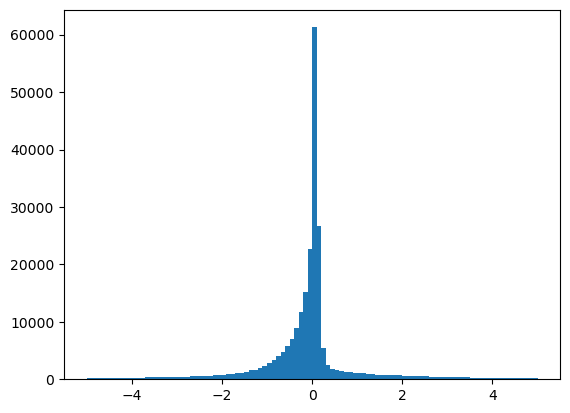

In [3]:
plt.hist(y_pred_test-y_test, bins=100, range=[-5,5])

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-60. , -58.8, -57.6, -56.4, -55.2, -54. , -52.8, -51.6, -50.4,
        -49.2, -48. , -46.8, -45.6, -44.4, -43.2, -42. , -40.8, -39.6,
        -38.4, -37.2, -36. , -34.8, -33.6, -32.4, -31.2, -30. , -28.8,
        -27.6, -26.4, -25.2, -24. , -22.8, -21.6, -20.4, -19.2, -18. ,
        -16.8, -15.6, -14.4, -13.2, -12. , -10.8,  -9.6,  -8.4,  -7.2,
         -6. ,  -4.8,  -3.6,  -2.4,  -1.2,   0. ,   1.2,   2.4,   3.6,
          4.8,   6. ,   7.2,   8.4,   9.6,  10.8,  12. ,  13.2,  14.4,
         15.6,  16.8,  18. ,  19.2,  20.4,  21.6,  22.8,  24. ,  25.2,
         26.4,  27.6,  28.8,  30. ,  31.2,  32.4,  33.6,  34.8,  36. ,
         37.2,  38.4,  39.6,  40.8,  42. ,  43.2,  44.4,  45.6,  46.8,
     

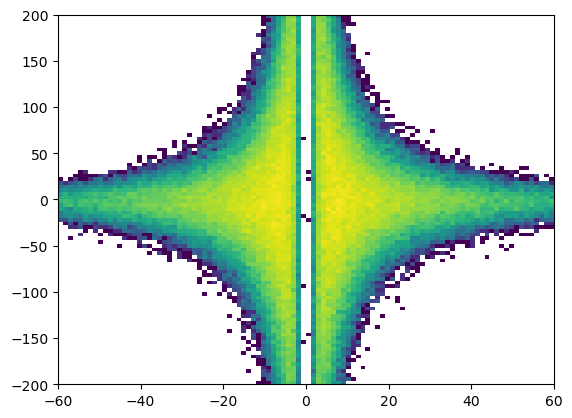

In [4]:
noise = np.random.normal(0, 0.15, X_test[:,2].shape)
noisey_X_test = X_test.copy()
noisey_X_test[:, 2] = 1./(1./noisey_X_test[:,2] + noise * (1./noisey_X_test[:,2]))
noisey_X_test[:, 3] = noisey_X_test[:, 2] * np.sign( noisey_X_test[:, 3] )
noisey_X_test_model = np.delete( poly.fit_transform( noisey_X_test ), remove, axis=1)
noisy_y_pred_test = lin_reg.predict( noisey_X_test_model )
plt.figure()
plt.hist2d(np.sign(noisey_X_test[:, 3])/noisey_X_test[:, 2], noisy_y_pred_test - y_test, bins=100, range=[[-60,60], [-200,200]],cmin=1, norm=matplotlib.colors.LogNorm())